In [22]:
%matplotlib inline

import gc

import os
os.environ['MPLBACKEND'] = 'agg'

import subprocess

# import tables

import itertools

import pandas as pd
import numpy as np
import pylab
import re


import scipy.stats as stats
import scipy

# load statsmodels as alias ``sm``
import statsmodels.api as sm


import matplotlib
# Force matplotlib to not use any Xwindows backend.
#matplotlib.use('Agg')


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib.backends.backend_svg import SVG
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import ScalarFormatter
#for displying pandas tables inside Jupyter
from IPython.display import display, HTML

In [23]:
last_gene_row=63678
last_ercc_row=63770

project_root = "/gs/project/wst-164-ab/share/expr/a026-x056-1876-e12"
exper_name = "a026-E12"
datasets = {"gene": ["matr/all.readcnt.known.genes.csv", 0, last_gene_row-1],
            "ercc": ["matr/all.readcnt.known.genes.csv", last_gene_row-1, last_ercc_row-1]}

In [24]:
first_sc_col=15
last_sc_col=88
run_datasets = [
    ["ercc-egfrn", "ercc", "ERCC expression of single cell subsets E12 1876 PDX EGFR negative",  range(first_sc_col-1, last_sc_col), "Single cells subset [cardinality]", [5-1, 6-1], "Average of bulk cells [$R^2$]"],
    ["gene-egfrn", "gene", "Gene expression of single cell subsets E12 1876 PDX EGFR negative",  range(first_sc_col-1, last_sc_col), "Single cells subset [cardinality]", [5-1, 6-1], "Average of bulk cells [$R^2$]"],
    ["ercc-egfrp", "ercc", "ERCC expression of single cell subsets E12 1876 PDX EGFR positive",  range(first_sc_col-1, last_sc_col), "Single cells subset [cardinality]", [7-1, 8-1], "Average of bulk cells [$R^2$]"],
    ["gene-egfrp", "gene", "Gene expression of single cell subsets E12 1876 PDX EGFR positive",  range(first_sc_col-1, last_sc_col), "Single cells subset [cardinality]", [7-1, 8-1], "Average of bulk cells [$R^2$]"],
    ["ercc-tc1000", "ercc", "ERCC expression of single cell subsets E12 1876 PDX TC_1000",  range(first_sc_col-1, last_sc_col), "Single cells subset [cardinality]", [9-1, 10-1], "Average of bulk cells [$R^2$]"],
    ["gene-tc1000", "gene", "Gene expression of single cell subsets E12 1876 PDX TC_1000",  range(first_sc_col-1, last_sc_col), "Single cells subset [cardinality]", [9-1, 10-1], "Average of bulk cells [$R^2$]"],
    ["ercc-tc200", "ercc", "ERCC expression of single cell subsets E12 1876 PDX TC_200",  range(first_sc_col-1, last_sc_col), "Single cells subset [cardinality]", [11-1, 12-1], "Average of bulk cells [$R^2$]"],
    ["gene-tc200", "gene", "Gene expression of single cell subsets E12 1876 PDX TC_200",  range(first_sc_col-1, last_sc_col), "Single cells subset [cardinality]", [11-1, 12-1], "Average of bulk cells [$R^2$]"],
    ["ercc-tcrneasy", "ercc", "ERCC expression of single cell subsets E12 1876 PDX TC_RNeasy",  range(first_sc_col-1, last_sc_col), "Single cells subset [cardinality]", [13-1, 14-1], "Average of bulk cells [$R^2$]"],
    ["gene-tcrneasy", "gene", "Gene expression of single cell subsets E12 1876 PDX TC_RNeasy",  range(first_sc_col-1, last_sc_col), "Single cells subset [cardinality]", [13-1, 14-1], "Average of bulk cells [$R^2$]"],
                     ]
run_datasets = [
    ["mirna-ercc-mimic_tc200", "ercc", "ERCC expression correlation MCF7",  range(first_sc_col-1, last_sc_col), "Average of single cells [log2(CNT+1)]", [4-1, 5-1], "Average of bulk cells [log2(CNT+1)]"],
    ["mirna-gene-mimic_tc200", "norm", "Genetic expression correlation MCF7",  range(first_sc_col-1, last_sc_col), "Average of single cells [log2(CNT+1)]", [4-1, 5-1], "Average of bulk cells [log2(CNT+1)]"],
                     ]

In [25]:
global y_cols_df
global x_cols_df
global y_cols_avg
global x_cols_avg
global y_cols_arr
global x_cols_arr
global edf
global edf2
global x_col_range
global y_col_range
global x_title
global y_title

In [26]:
def read_expr(file):

    print("file: ", file)
    expr = pd.read_csv(file, sep=',', header=0
                                 # index_col=[0]
                                 # usecols=[0, 1],
                                 # names=["transcript_id", "ex"]
                          )
    # filter zeros
    # expr = expr.query('ex != 0.0')
    # print("expr: \n", expr.iloc[:,0:3])
    return expr

In [27]:
def extract_dataset(dtst_name):
    global y_cols_df
    global x_cols_df
    global y_cols_avg
    global x_cols_avg
    global y_cols_arr
    global x_cols_arr
    global edf
    global edf2
    global x_col_range
    global y_col_range
    global x_title
    global y_title
    # extract dataset information
    dtst_file, dtst_min_row, dtst_max_row = datasets[dtst_name]
    
    edf = read_expr(os.path.join(project_root, dtst_file))
    print("edf.shape: ", edf.shape)
    
    edf2 = edf.query(r"""index >= %s & index <%s""" % (dtst_min_row, dtst_max_row))
    edf2_len = edf2.shape[0]
    #print(edf2.head(3))


In [28]:
global edf2
extract_dataset("ercc")
edf3 = edf2.iloc[:, range(3,last_sc_col)]
totexpercc=edf3.sum(axis=0)

extract_dataset("gene")
edf3 = edf2.iloc[:, range(3, last_sc_col)]
totexpnorm=edf3.sum(axis=0)

#HTML(edf2.head(3).to_html())
#totexpdf=edf3.sum(axis=0)
#HTML(edf2_ERCC.head(3).to_html())
d = {'ercc': totexpercc.values, 'norm': totexpnorm.values}
df = pd.DataFrame(data=d, index=totexpercc.index)
df["directratio"]=df["norm"]/df["ercc"]
df["normratio"]=df["norm"]/(df["norm"]+df["ercc"])
df.sort_values(by=['normratio'],inplace=True, ascending=False)
#print(df.index.values)

#print(totexpnorm.head(3).values)
#print(totexpnorm.index.values)


#edf3 = edf2.iloc[:, range(3, last_sc_col)]

HTML(edf2.head(3).to_html())
#edf3.sum(axis=0)
#edf3.to_html()


file:  /gs/project/wst-164-ab/share/expr/a026-x056-1876-e12/matr/all.readcnt.known.genes.csv
edf.shape:  (63772, 88)
file:  /gs/project/wst-164-ab/share/expr/a026-x056-1876-e12/matr/all.readcnt.known.genes.csv
edf.shape:  (63772, 88)


['B_C49-a026' 'WB_C58-a026' 'TC_RNEASY_1OF2-a026'
 'EGFRp_TC_RNEASY_2OF2-a026' 'TC_RNEASY_2OF2-a026' 'WB_C61-a026'
 'WB_C65-a026' 'B_C14-a026' 'EGFRp_TC_RNEASY_1OF2-a026' 'LBor2B_C96-a026'
 'B_C15-a026' 'B_C66-a026' 'B_C02-a026' 'B_C50-a026' 'WB_C07-a026'
 'B_C81-a026' 'B_C54-a026' 'LBor2B_C76-a026' 'B_C53-a026' 'WB_C13-a026'
 'LBor2B_C06-a026' 'B_C23-a026' 'EGFRn_TC_RNEASY_1OF2-a026'
 'TC_1000_1OF2-a026' 'WB_C56-a026' 'B_C67-a026' 'B_C70-a026' 'B_C18-a026'
 'EGFRn_TC_RNEASY_2OF2-a026' 'B_C05-a026' 'WB_C55-a026' 'B_C95-a026'
 'WB_C10-a026' 'TC_200_1OF2-a026' 'B_C82-a026' 'B_C94-a026'
 'TC_1000_2OF2-a026' 'B_C85-a026' 'WB_C41-a026' 'WB_C64-a026' 'B_C29-a026'
 'WB_C25-a026' 'B_C84-a026' 'WB_C73-a026' 'TC_200_2OF2-a026' 'WB_C74-a026'
 'B_C30-a026' 'WB_C62-a026' 'WB_C43-a026' 'B_C35-a026' 'B_C83-a026'
 'B_C93-a026' 'B_C33-a026' 'B_C89-a026' 'B_C80-a026' 'B_C21-a026'
 'B_C22-a026' 'B_C51-a026' 'WB_C39-a026' 'B_C71-a026' 'WB_C17-a026'
 'WB_C47-a026' 'WB_C38-a026' 'B_C42-a026' 'B_C32-a026' 'B

FileNotFoundError: [Errno 2] No such file or directory: '../figs/fig_3a-ercc-gene-ratio.png'

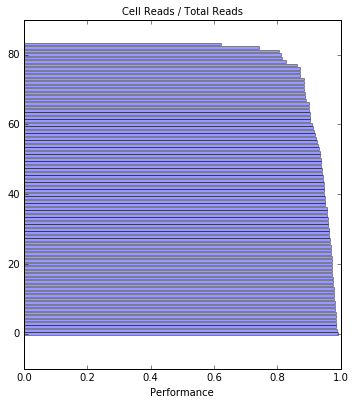

In [29]:
fig = plt.figure(figsize=(16,12))

# plt.set_dpi(100)
# fig.subplots_adjust(bottom=0.1)
ax = fig.add_subplot(111)

plt.subplots_adjust(top=0.98, bottom=0.01, left=0.10, right=0.98, hspace = 0.1, wspace = 0.2)
# plt.tight_layout()

fig.set_size_inches(5, 5)


#ax.set_xlabel(x_title, fontsize= 8)
#ax.set_ylabel(y_title, fontsize= 8)

samples=df.index.values
print(samples)
rows = np.arange(len(samples))

x_arr = rows
z_arr = df.index.values

y_arr = df["normratio"].values
plt.barh(x_arr, y_arr, align='center', alpha=0.4)

#plt.yticks(rows, df.index.values)
plt.xlabel('Performance')
plt.title('Cell Reads / Total Reads',  fontsize= 10)

#plt.barh(y_pos, performance, xerr=error, align='center', alpha=0.4)
#plt.yticks(y_pos, people)
#plt.xlabel('Performance')
#plt.title('How fast do you want to go today?')

plt.savefig("../figs/fig_3a-%s.png" % anal_name, format="png", dpi=400)  # saves the current figure into a pdf page
plt.show()

plt.close()
HTML(df.to_html())


85


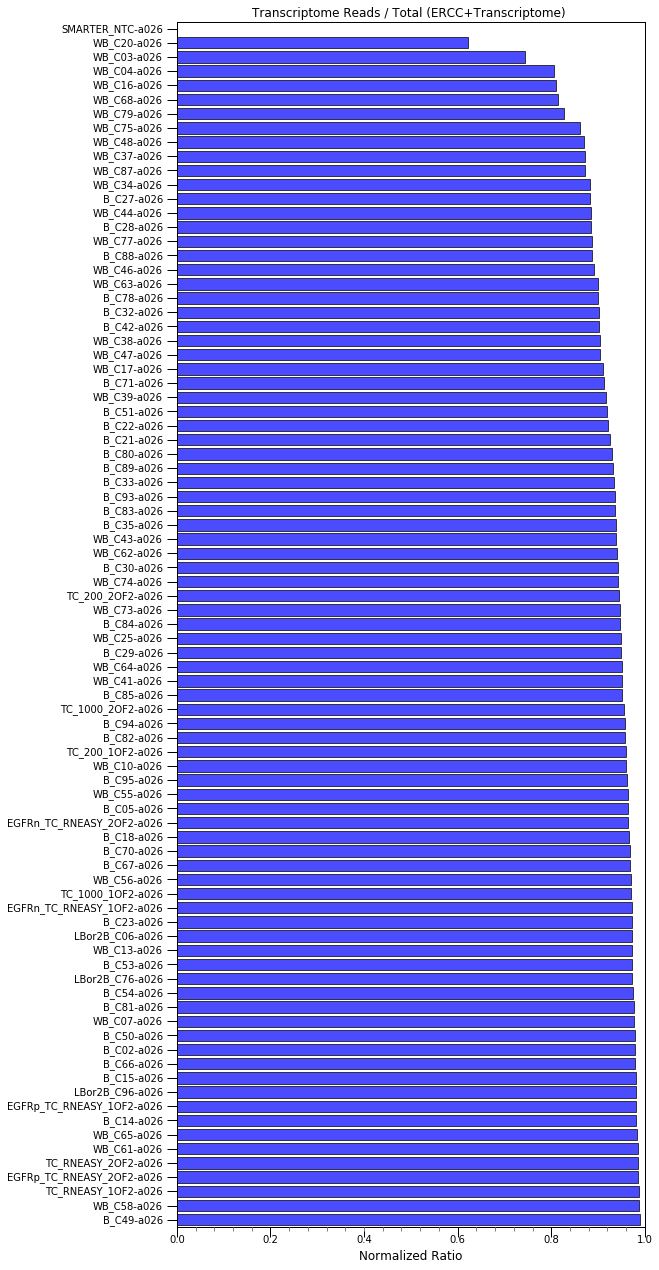

In [30]:
anal_name = "ercc-gene-ratio"


val=df["normratio"].values
labs=df.index.values
pos = np.arange(len(val))
#print("val: ", val)
#print("pos: ", pos)
print(len(val))

#fig = plt.figure(figsize=(10,16))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.barh(pos, val,color='b',align='center', alpha=0.7, lw=1)
ax.set_yticks(pos)
ax.set_yticklabels(labs, fontsize= 10)
ax.set_xlabel('Normalized Ratio', fontsize= 12)
#ax.set_ylabel(y_title, fontsize= 8)

ax.set_title('Transcriptome Reads / Total (ERCC+Transcriptome) ', fontsize= 12)
ax.set_xlim(0, 1)

plt.ylim((-0.5,len(val)-0.5))

#plt.xlabel('Normalized Ratio')
#plt.title('Transcriptome Reads / Total (ERCC+Transcriptome) ',  fontsize= 10)

#plt.barh(y_pos, performance, xerr=error, align='center', alpha=0.4)
#plt.yticks(y_pos, people)
#plt.xlabel('Performance')
#plt.title('How fast do you want to go today?')

#plt.title(fig_title,  fontsize= 10)

#plt.tight_layout()

fig.set_size_inches(10,18)
plt.subplots_adjust(top=0.98, bottom=0.05, left=0.30, right=0.95, hspace = 0.1, wspace = 0.2)

# axis
ax.get_xaxis().set_tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
#ax.xaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
#ax.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='both', width=1)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=4, color='gray', direction='out')

ax.yaxis.set_tick_params(direction='out')
ax.yaxis.set_tick_params(left='on', right='off')

#ax.yaxis.set_tick_params(which='both', width=1)
#ax.yaxis.set_tick_params(which='major', length=10)
#ax.get_yaxis().set_tick_params(which='minor', length=4, color='gray')

    
#plt.savefig("../figs/fig_4a-%s.png" % anal_name, format="png", dpi=400)  # saves the current figure into a pdf page
plt.savefig("../sc_qc/figs/%s-fig3-%s.png" % (exper_name, anal_name), format="pdf")  # saves the current figure into a pdf page

plt.show()
plt.close()

In [32]:
%load_ext rpy2.ipython

In [ ]:
#%%R -i x_arr,y_arr,z_arr -o res
#par(mfrow=c(1,1))
#layout(matrix(c(1,1), 1, byrow = TRUE),
#   widths=c(1), heights=c(1))

#layout(mat, widths = rep.int(1, ncol(mat)),
#       heights = rep.int(1, nrow(mat)), respect = FALSE)

#layout.show(n = 1)
#lcm(x)

#png(filename="faithful.png")
#png()
#layout(matrix(c(1:10),5,2),heights=c(1,rep(2,4)))
#par("mar") 
#par(pin=c(3,6)) 
#res = 1
#barplot(x_arr, main="Car Distribution", horiz=TRUE,
#  names.arg=z_arr, las=1)